# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [ ]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1010,q12145655O,Skoda Rapid,economy,petrol,4.18,2017,117974,2015,29.75,engine_overheat
1796,U-1298358e,Hyundai Solaris,economy,petrol,5.02,2014,70581,2018,35.65,engine_fuel
618,W-1949796N,Nissan Qashqai,standart,petrol,4.12,2013,43877,2016,30.80,engine_overheat
377,p22837387w,VW Tiguan,economy,petrol,3.76,2017,131667,2017,24.26,engine_fuel
2007,M10208049m,Audi A4,premium,petrol,4.26,2017,109507,2019,63.82,engine_overheat


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [ ]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
231302,H11434748M,Q-2259244S,b1p,2020-01-30,10.00,46,547,49,55.000000,0,2294.962285,0,8.458220,-0.000
389293,C20024510R,b12102660G,u1M,2020-01-30,3.26,13,178,37,62.000000,1,392.244018,0,2.471396,19.227
23261,d18231683N,B13169162p,P1v,2020-03-04,4.13,55,655,54,114.000000,1,2305.117286,0,3.441090,-4.079
689514,D32465922h,w-8712305w,t1e,2020-03-08,6.55,12,151,42,138.000000,1,454.990308,0,29.662635,-3.073
497735,I21795865k,j-1317678J,w1u,2020-02-20,5.12,21,245,49,83.516247,0,796.436666,0,4.400269,-3.962


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [ ]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
4606,34,7.4,638,8.0,f41834419Q,0,2019-5-28
11672,36,8.2,1677,7.0,k56817562H,0,2021-7-24
10607,31,9.3,1001,18.0,E19886650r,1,2020-11-4
2869,24,8.2,1873,7.0,I73892988G,1,2018-4-12
166,37,7.9,2031,4.0,Y21918575C,1,2018-3-2


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [ ]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
35855,t-2297441l,MF,2019-5-20 11:9,repair,4.9,9
41722,p-1077837n,MV,2019-8-17 0:37,reparking,1.0,19
101631,H-2108091L,KX,2020-6-22 22:27,repair,10.0,48
6281,d-2251789J,QV,2019-9-15 16:16,reparking,1.0,28
33577,C17311656B,EP,2018-7-11 14:14,reparking,1.0,35


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [ ]:
# Пример расчета одного признака
rides_info.groupby('car_id', as_index=False).agg(
    mean_rating = ('rating', 'mean'),
    # ... еще признаки
)

df = pd.merge(...) # Соедините полученный датасет с фичами с основным датасетом

# YOUR CODE HERE

TypeError: merge() missing 1 required positional argument: 'right'

### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

# РЕШЕНИЕ: вспомогательная логика

In [ ]:
def check_data_distribution(df, threshold = 1e+12):
    df.info()
    print(f'Размерность: {df.shape}')

    numeric_dataset = df.select_dtypes(include=[np.number, 'float32', 'float64', 'Int64', 'int64', 'int32', 'int8'])

    # проверить inf
    columns_with_inf = []

    for column in numeric_dataset:
        if np.isinf(numeric_dataset[column]).any():
            columns_with_inf.append(column)

    print(f'Кол-во признаков с Infinite Values: {len(columns_with_inf)}')

    # проверить na
    total_nan = df.isnull().sum().sum()

    print(f'Кол-во Nan: {total_nan}')

    # проверить модуль, макс и мин
    abs_max_in_columns = numeric_dataset.abs().max()

    excessively_large_values_in_columns = abs_max_in_columns[abs_max_in_columns > threshold].index
    print("Признаки с большими значениями по модулю:", excessively_large_values_in_columns)

    min_value = numeric_dataset.min().min()
    max_value = numeric_dataset.max().max()

    print("Минимум набора:", min_value)
    print("Максимум набора:", max_value)

    # проверить дубликаты
    print(f'Дубликаты в рядах: {any(df.duplicated())}')
    print(f'Дубликаты в столбцах: {any(df.columns.duplicated())}')

    # проверить неинформативные признаки
    print(f'Неинформативные признаки: {[col for col in numeric_dataset if df[col].nunique() == 1]}')


def analyze_dataset_columns(dataset):
    for col in dataset.columns:
        print(f"~Уникальные значения для столбца {col}~: {dataset[col].nunique()}")
        print(f"~Кол-во дубликатов для столбца {col}~: {dataset[col].duplicated().sum()}")
        print(f"~Первые 3 val counts для столбца {col}~:")
        print(dataset[col].value_counts().head(3))
        print(f"~Кол-во пропущенных значений для столбца {col}~: {dataset[col].isna().sum()}")

def get_group_duplicates(dataset, features):
    subset_duplicates = dataset.duplicated(subset=features).sum()
    print(f"~Кол-во дубликатов для столбцов {', '.join(features)}~: {subset_duplicates}")


In [ ]:
check_data_distribution(rides_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739500 entries, 0 to 739499
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            739500 non-null  object 
 1   car_id             739500 non-null  object 
 2   ride_id            739500 non-null  object 
 3   ride_date          739500 non-null  object 
 4   rating             739500 non-null  float64
 5   ride_duration      739500 non-null  int64  
 6   ride_cost          739500 non-null  int64  
 7   speed_avg          739500 non-null  int64  
 8   speed_max          736139 non-null  float64
 9   stop_times         739500 non-null  int64  
 10  distance           739500 non-null  float64
 11  refueling          739500 non-null  int64  
 12  user_ride_quality  736872 non-null  float64
 13  deviation_normal   739500 non-null  float64
dtypes: float64(5), int64(5), object(4)
memory usage: 79.0+ MB
Размерность: (739500, 14)
Кол-во признаков

In [ ]:
analyze_dataset_columns(rides_info)

~Уникальные значения для столбца user_id~: 15153
~Кол-во дубликатов для столбца user_id~: 724347
~Первые 3 val counts для столбца user_id~:
n50223955s    153
I27349458O    149
W13073879n    149
Name: user_id, dtype: int64
~Кол-во пропущенных значений для столбца user_id~: 0
~Уникальные значения для столбца car_id~: 4250
~Кол-во дубликатов для столбца car_id~: 735250
~Первые 3 val counts для столбца car_id~:
A-1049127W    174
i30546413z    174
i17810499T    174
Name: car_id, dtype: int64
~Кол-во пропущенных значений для столбца car_id~: 0
~Уникальные значения для столбца ride_id~: 2704
~Кол-во дубликатов для столбца ride_id~: 736796
~Первые 3 val counts для столбца ride_id~:
k1y    330
V1C    329
l1j    326
Name: ride_id, dtype: int64
~Кол-во пропущенных значений для столбца ride_id~: 0
~Уникальные значения для столбца ride_date~: 93
~Кол-во дубликатов для столбца ride_date~: 739407
~Первые 3 val counts для столбца ride_date~:
2020-01-01    8039
2020-01-31    8039
2020-03-02    8039
Nam

In [ ]:
get_group_duplicates(rides_info, ['car_id', 'ride_id', 'user_id'])

~Кол-во дубликатов для столбцов car_id, ride_id, user_id~: 0


In [ ]:
get_group_duplicates(rides_info, ['car_id', 'ride_id'])

~Кол-во дубликатов для столбцов car_id, ride_id~: 23152


In [ ]:
rides_info.sort_values(by=['ride_id']).head(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
300570,L10406820V,V-2042242Z,A1A,2020-02-08,1.51,35,487,31,68.000000,0,1146.081312,0,-0.722598,-19.988
706224,g17416818c,x38176093d,A1A,2020-03-11,2.41,105,775,89,144.023173,0,3719.312403,0,-10.194232,0.042
616659,R48112572R,r16294059S,A1A,2020-01-03,9.22,21,249,36,51.000000,1,624.416040,0,-0.401222,0.494
393122,A17826012p,b35718807I,A1A,2020-01-30,7.13,12719,101747,39,75.000000,1,504300.062724,0,13.026031,7.629
357289,i29678357d,Z16406378j,A1A,2020-02-05,5.72,30,296,43,73.000000,1,554.429170,0,1.488879,-11.979


In [ ]:
rides_info.sort_values(by=['ride_id']).head(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
300570,L10406820V,V-2042242Z,A1A,2020-02-08,1.51,35,487,31,68.000000,0,1146.081312,0,-0.722598,-19.988
706224,g17416818c,x38176093d,A1A,2020-03-11,2.41,105,775,89,144.023173,0,3719.312403,0,-10.194232,0.042
616659,R48112572R,r16294059S,A1A,2020-01-03,9.22,21,249,36,51.000000,1,624.416040,0,-0.401222,0.494
393122,A17826012p,b35718807I,A1A,2020-01-30,7.13,12719,101747,39,75.000000,1,504300.062724,0,13.026031,7.629
357289,i29678357d,Z16406378j,A1A,2020-02-05,5.72,30,296,43,73.000000,1,554.429170,0,1.488879,-11.979


# РЕШЕНИЕ: Задание 1. Генерация признаков
*Пункты 1,2,3,4,5*
  
Возьмите датасет rides_info с информацией о поездках и проведите группировку по каждой машине отдельно.
Для каждой машины (то есть для каждого car_id) подсчитайте несколько признаков:

    минимальный рейтинг за все поездки;
    средний рейтинг за все поездки;
    общее количество километров, которое машина проехала;
    максимальная скорость;
    общее количество поездок для каждой машины.

Добавьте минимум 3 признака на свой выбор.
Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.
Подключите информацию про водителей (driver_info) и про ремонт машин (fix_info). Добавьте минимум 3 любых признака с каждого датасета.



In [ ]:
def aggregate_rides_info(rides_info_df, driver_info_df):
    # объединим с driver info
    merged_df = pd.merge(rides_info_df, driver_info_df, on='user_id', how='left')

    aggregated_df = merged_df.groupby('car_id').agg(
        min_rating=('rating', 'min'),
        avg_rating=('rating', 'mean'),
        total_distance=('distance', 'sum'),
        max_speed=('speed_max', 'max'),
        total_rides=('car_id', 'size'),
        sum_user_rides=('user_rides', 'sum'),  # 1й новый признак из driver_info
        sum_user_time_accident=('user_time_accident', 'sum'),  # 2й новый признак из driver_info
        mean_user_time_accident=('user_time_accident', 'mean'),  # 3й новый признак из driver_info
        deviation_normal_mean=('deviation_normal', 'mean'), # 1й новый признак из rides_info
        deviation_normalmin_max_diff=('deviation_normal', lambda x: x.max() - x.min()), # 2й новый признак из rides_info
    ).reset_index()

    threshold = merged_df['deviation_normal'].quantile(0.75)
    counts_above_threshold = merged_df[merged_df['deviation_normal'] > threshold].groupby('car_id').size().reset_index(name='count_above_75th') # 3й новый признак из rides_info

    # Merge the counts above threshold back into the aggregated data
    final_df = pd.merge(aggregated_df, counts_above_threshold, on='car_id', how='left')
    final_df['count_above_75th'] = final_df['count_above_75th'].fillna(0)

    return final_df

In [ ]:
rides_driver_info_merged_agg = aggregate_rides_info(rides_info, driver_info)

In [ ]:
rides_driver_info_merged_agg.head(10)

,car_id,min_rating,avg_rating,total_distance,max_speed,total_rides,sum_user_rides,sum_user_time_accident,mean_user_time_accident,deviation_normal_mean,deviation_normalmin_max_diff,count_above_75th
0,A-1049127W,0.10,4.255172,1.125753e+07,179.729652,174,146833,1618.0,9.298851,-6.136672,31.688,0.0
1,A-1079539w,0.10,4.088046,1.912765e+07,184.505566,174,153870,1559.0,8.959770,47.443270,74.349,168.0
2,A-1162143G,0.10,4.662299,2.995194e+06,180.000000,174,148344,2217.0,17.736000,10.556425,46.177,113.0
3,A-1228282M,0.10,4.225172,1.793685e+07,182.446070,174,158618,1381.0,7.936782,9.810747,64.898,84.0
4,A-1339912r,0.10,4.690115,1.202552e+07,152.000000,174,139218,2112.0,18.051282,22.965937,40.142,162.0
5,A-1463575c,0.10,4.510805,1.681067e+07,161.000000,174,154631,1998.0,17.224138,-2.293339,13.900,0.0
6,A-1680490U,0.96,5.453736,1.526994e+07,109.355027,174,151106,1430.0,8.218391,-6.998305,28.998,0.0
7,A-1683178f,0.10,4.337299,2.130874e+07,177.034172,174,151988,1751.0,15.226087,9.955155,52.401,91.0
8,A-1721538a,0.10,5.606207,1.674416e+07,112.927322,174,151236,1414.0,8.126437,-2.003155,8.301,0.0
9,A-1737634s,0.10,4.347701,1.104011e+07,104.658255,174,164187,1453.0,8.350575,-18.673575,68.741,4.0


In [ ]:
check_data_distribution(rides_driver_info_merged_agg)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4250 entries, 0 to 4249
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        4250 non-null   object 
 1   min_rating                    4250 non-null   float64
 2   avg_rating                    4250 non-null   float64
 3   total_distance                4250 non-null   float64
 4   max_speed                     4250 non-null   float64
 5   total_rides                   4250 non-null   int64  
 6   sum_user_rides                4250 non-null   int64  
 7   sum_user_time_accident        4250 non-null   float64
 8   mean_user_time_accident       4250 non-null   float64
 9   deviation_normal_mean         4250 non-null   float64
 10  deviation_normalmin_max_diff  4250 non-null   float64
 11  count_above_75th              4250 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 431.6+ KB
Раз

In [ ]:
analyze_dataset_columns(rides_driver_info_merged_agg)

~Уникальные значения для столбца car_id~: 4250
~Кол-во дубликатов для столбца car_id~: 0
~Первые 3 val counts для столбца car_id~:
A-1049127W    1
i30546413z    1
i17810499T    1
Name: car_id, dtype: int64
~Кол-во пропущенных значений для столбца car_id~: 0
~Уникальные значения для столбца min_rating~: 107
~Кол-во дубликатов для столбца min_rating~: 4143
~Первые 3 val counts для столбца min_rating~:
0.10    3172
0.00     470
0.19      19
Name: min_rating, dtype: int64
~Кол-во пропущенных значений для столбца min_rating~: 0
~Уникальные значения для столбца avg_rating~: 3892
~Кол-во дубликатов для столбца avg_rating~: 358
~Первые 3 val counts для столбца avg_rating~:
4.416782    4
4.557874    4
4.357069    4
Name: avg_rating, dtype: int64
~Кол-во пропущенных значений для столбца avg_rating~: 0
~Уникальные значения для столбца total_distance~: 4250
~Кол-во дубликатов для столбца total_distance~: 0
~Первые 3 val counts для столбца total_distance~:
1.125753e+07    1
8.903183e+06    1
1.5042

In [ ]:
check_data_distribution(car_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_id         2337 non-null   object 
 1   model          2337 non-null   object 
 2   car_type       2337 non-null   object 
 3   fuel_type      2337 non-null   object 
 4   car_rating     2337 non-null   float64
 5   year_to_start  2337 non-null   int64  
 6   riders         2337 non-null   int64  
 7   year_to_work   2337 non-null   int64  
 8   target_reg     2337 non-null   float64
 9   target_class   2337 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 182.7+ KB
Размерность: (2337, 10)
Кол-во признаков с Infinite Values: 0
Кол-во Nan: 0
Признаки с большими значениями по модулю: Index([], dtype='object')
Минимум набора: 0.98
Максимум набора: 142862.0
Дубликаты в рядах: False
Дубликаты в столбцах: False
Неинформативные признаки: []


In [ ]:
analyze_dataset_columns(car_train)

~Уникальные значения для столбца car_id~: 2337
~Кол-во дубликатов для столбца car_id~: 0
~Первые 3 val counts для столбца car_id~:
y13744087j    1
s48916749r    1
T77801635B    1
Name: car_id, dtype: int64
~Кол-во пропущенных значений для столбца car_id~: 0
~Уникальные значения для столбца model~: 26
~Кол-во дубликатов для столбца model~: 2311
~Первые 3 val counts для столбца model~:
Hyundai Solaris    161
Smart ForFour      158
Renault Kaptur     154
Name: model, dtype: int64
~Кол-во пропущенных значений для столбца model~: 0
~Уникальные значения для столбца car_type~: 4
~Кол-во дубликатов для столбца car_type~: 2333
~Первые 3 val counts для столбца car_type~:
economy     1536
standart     599
business     117
Name: car_type, dtype: int64
~Кол-во пропущенных значений для столбца car_type~: 0
~Уникальные значения для столбца fuel_type~: 2
~Кол-во дубликатов для столбца fuel_type~: 2335
~Первые 3 val counts для столбца fuel_type~:
petrol     2289
electro      48
Name: fuel_type, dtype: 

In [ ]:
check_data_distribution(driver_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15153 entries, 0 to 15152
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 15153 non-null  int64  
 1   user_rating         15153 non-null  float64
 2   user_rides          15153 non-null  int64  
 3   user_time_accident  14182 non-null  float64
 4   user_id             15153 non-null  object 
 5   sex                 15153 non-null  int64  
 6   first_ride_date     15153 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 828.8+ KB
Размерность: (15153, 7)
Кол-во признаков с Infinite Values: 0
Кол-во Nan: 971
Признаки с большими значениями по модулю: Index([], dtype='object')
Минимум набора: 0.0
Максимум набора: 3316.0
Дубликаты в рядах: False
Дубликаты в столбцах: False
Неинформативные признаки: []


In [ ]:
analyze_dataset_columns(driver_info)

~Уникальные значения для столбца age~: 46
~Кол-во дубликатов для столбца age~: 15107
~Первые 3 val counts для столбца age~:
18    1130
40     518
36     505
Name: age, dtype: int64
~Кол-во пропущенных значений для столбца age~: 0
~Уникальные значения для столбца user_rating~: 43
~Кол-во дубликатов для столбца user_rating~: 15110
~Первые 3 val counts для столбца user_rating~:
8.0    907
8.1    906
8.2    896
Name: user_rating, dtype: int64
~Кол-во пропущенных значений для столбца user_rating~: 0
~Уникальные значения для столбца user_rides~: 1800
~Кол-во дубликатов для столбца user_rides~: 13353
~Первые 3 val counts для столбца user_rides~:
881     51
757     46
1146    46
Name: user_rides, dtype: int64
~Кол-во пропущенных значений для столбца user_rides~: 0
~Уникальные значения для столбца user_time_accident~: 84
~Кол-во дубликатов для столбца user_time_accident~: 15068
~Первые 3 val counts для столбца user_time_accident~:
6.0    843
3.0    794
8.0    777
Name: user_time_accident, dtype

In [ ]:
check_data_distribution(fix_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146000 entries, 0 to 145999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   car_id          146000 non-null  object 
 1   worker_id       146000 non-null  object 
 2   fix_date        146000 non-null  object 
 3   work_type       146000 non-null  object 
 4   destroy_degree  146000 non-null  float64
 5   work_duration   146000 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB
Размерность: (146000, 6)
Кол-во признаков с Infinite Values: 0
Кол-во Nan: 0
Признаки с большими значениями по модулю: Index([], dtype='object')
Минимум набора: 1.0
Максимум набора: 74.0
Дубликаты в рядах: False
Дубликаты в столбцах: False
Неинформативные признаки: []


In [ ]:
analyze_dataset_columns(fix_info)

~Уникальные значения для столбца car_id~: 4250
~Кол-во дубликатов для столбца car_id~: 141750
~Первые 3 val counts для столбца car_id~:
P17494612l    35
k-1039028Y    35
l-5953507c    35
Name: car_id, dtype: int64
~Кол-во пропущенных значений для столбца car_id~: 0
~Уникальные значения для столбца worker_id~: 546
~Кол-во дубликатов для столбца worker_id~: 145454
~Первые 3 val counts для столбца worker_id~:
CH    321
FZ    306
EY    306
Name: worker_id, dtype: int64
~Кол-во пропущенных значений для столбца worker_id~: 0
~Уникальные значения для столбца fix_date~: 138311
~Кол-во дубликатов для столбца fix_date~: 7689
~Первые 3 val counts для столбца fix_date~:
2019-7-28 11:46    4
2020-8-17 5:11     4
2019-3-16 6:19     4
Name: fix_date, dtype: int64
~Кол-во пропущенных значений для столбца fix_date~: 0
~Уникальные значения для столбца work_type~: 6
~Кол-во дубликатов для столбца work_type~: 145994
~Первые 3 val counts для столбца work_type~:
repair          67733
reparking       60533
r

In [ ]:
get_group_duplicates(fix_info, ['car_id', 'fix_date', 'work_type'])

~Кол-во дубликатов для столбцов car_id, fix_date, work_type~: 1


In [ ]:
get_group_duplicates(fix_info, ['car_id', 'fix_date', 'work_type', 'worker_id'])

~Кол-во дубликатов для столбцов car_id, fix_date, work_type, worker_id~: 0


In [ ]:
def aggregate_fix_info(df):
    aggregated_df = df.groupby('car_id').agg(
        repairs_count=('car_id', 'size'),
        avg_destroy_degree=('destroy_degree', 'mean'),
        total_work_duration=('work_duration', 'sum')
    ).reset_index()

    return aggregated_df

In [ ]:
fix_info_agg = aggregate_fix_info(fix_info)

In [ ]:
check_data_distribution(fix_info_agg)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_id               4250 non-null   object 
 1   repairs_count        4250 non-null   int64  
 2   avg_destroy_degree   4250 non-null   float64
 3   total_work_duration  4250 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 132.9+ KB
Размерность: (4250, 4)
Кол-во признаков с Infinite Values: 0
Кол-во Nan: 0
Признаки с большими значениями по модулю: Index([], dtype='object')
Минимум набора: 1.785294117647059
Максимум набора: 1203.0
Дубликаты в рядах: False
Дубликаты в столбцах: False
Неинформативные признаки: []


In [ ]:
# объединим rides_driver_info_merged_agg с fix_info_agg
rides_driver_fix_info_merged_agg = pd.merge(rides_driver_info_merged_agg, fix_info_agg, on='car_id', how='inner')

In [ ]:
check_data_distribution(rides_driver_fix_info_merged_agg)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4250 entries, 0 to 4249
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        4250 non-null   object 
 1   min_rating                    4250 non-null   float64
 2   avg_rating                    4250 non-null   float64
 3   total_distance                4250 non-null   float64
 4   max_speed                     4250 non-null   float64
 5   total_rides                   4250 non-null   int64  
 6   sum_user_rides                4250 non-null   int64  
 7   sum_user_time_accident        4250 non-null   float64
 8   mean_user_time_accident       4250 non-null   float64
 9   deviation_normal_mean         4250 non-null   float64
 10  deviation_normalmin_max_diff  4250 non-null   float64
 11  count_above_75th              4250 non-null   float64
 12  repairs_count                 4250 non-null   int64  
 13  avg

In [ ]:
check_data_distribution(car_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_id         2337 non-null   object 
 1   model          2337 non-null   object 
 2   car_type       2337 non-null   object 
 3   fuel_type      2337 non-null   object 
 4   car_rating     2337 non-null   float64
 5   year_to_start  2337 non-null   int64  
 6   riders         2337 non-null   int64  
 7   year_to_work   2337 non-null   int64  
 8   target_reg     2337 non-null   float64
 9   target_class   2337 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 182.7+ KB
Размерность: (2337, 10)
Кол-во признаков с Infinite Values: 0
Кол-во Nan: 0
Признаки с большими значениями по модулю: Index([], dtype='object')
Минимум набора: 0.98
Максимум набора: 142862.0
Дубликаты в рядах: False
Дубликаты в столбцах: False
Неинформативные признаки: []


In [ ]:
# объединим rides_driver_fix_info_merged_agg с car_train
rides_driver_fix_car_train_merged_left = pd.merge(car_train, rides_driver_fix_info_merged_agg, on='car_id', how='left')

In [ ]:
check_data_distribution(rides_driver_fix_car_train_merged_left)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   object 
 1   model                         2337 non-null   object 
 2   car_type                      2337 non-null   object 
 3   fuel_type                     2337 non-null   object 
 4   car_rating                    2337 non-null   float64
 5   year_to_start                 2337 non-null   int64  
 6   riders                        2337 non-null   int64  
 7   year_to_work                  2337 non-null   int64  
 8   target_reg                    2337 non-null   float64
 9   target_class                  2337 non-null   object 
 10  min_rating                    2337 non-null   float64
 11  avg_rating                    2337 non-null   float64
 12  total_distance                2337 non-null   float64
 13  max

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

# РЕШЕНИЕ: Задание 2: Фильтрация признаков

In [ ]:
analyze_dataset_columns(rides_driver_fix_car_train_merged_left)

~Уникальные значения для столбца car_id~: 2337
~Кол-во дубликатов для столбца car_id~: 0
~Первые 3 val counts для столбца car_id~:
y13744087j    1
s48916749r    1
T77801635B    1
Name: car_id, dtype: int64
~Кол-во пропущенных значений для столбца car_id~: 0
~Уникальные значения для столбца model~: 26
~Кол-во дубликатов для столбца model~: 2311
~Первые 3 val counts для столбца model~:
Hyundai Solaris    161
Smart ForFour      158
Renault Kaptur     154
Name: model, dtype: int64
~Кол-во пропущенных значений для столбца model~: 0
~Уникальные значения для столбца car_type~: 4
~Кол-во дубликатов для столбца car_type~: 2333
~Первые 3 val counts для столбца car_type~:
economy     1536
standart     599
business     117
Name: car_type, dtype: int64
~Кол-во пропущенных значений для столбца car_type~: 0
~Уникальные значения для столбца fuel_type~: 2
~Кол-во дубликатов для столбца fuel_type~: 2335
~Первые 3 val counts для столбца fuel_type~:
petrol     2289
electro      48
Name: fuel_type, dtype: 

In [195]:
import numpy as np
import pandas as pd

bug_dict = {
    'break_bug':   		0,
    'wheel_shake': 		1,
    'engine_check':		2,
    'engine_fuel': 		3,
    'electro_bug': 		4,
    'gear_stick':  		5,
    'engine_ignition':  6,
    'engine_overheat':  7,
    'another_bug': 		8
    }

label_to_bug_dict = {label: bug for bug, label in bug_dict.items()}

def encode_repair_types(df, bug_dict, repair_type_col='target_class'):
    df[repair_type_col] = df[repair_type_col].map(bug_dict)
    return df

def add_uniform_random_feature(df, feature_name='random_feature', low=0.0, high=1.0):
    df[feature_name] = np.random.uniform(low, high, size=df.shape[0])
    return df

In [ ]:
labeled_target_fitration_df = encode_repair_types(rides_driver_fix_car_train_merged_left, bug_dict, 'target_class')

In [ ]:
labeled_target_fitration_df['target_class'].unique()

array([8, 4, 5, 3, 6, 7, 2, 1, 0])

In [ ]:
labeled_target_fitration_df = add_uniform_random_feature(labeled_target_fitration_df)

In [ ]:
labeled_target_fitration_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   fuel_type                     2337 non-null   int64  
 4   car_rating                    2337 non-null   float64
 5   year_to_start                 2337 non-null   int64  
 6   riders                        2337 non-null   int64  
 7   year_to_work                  2337 non-null   int64  
 8   target_reg                    2337 non-null   float64
 9   target_class                  2337 non-null   int64  
 10  min_rating                    2337 non-null   float64
 11  avg_rating                    2337 non-null   float64
 12  total_distance                2337 non-null   float64
 13  max

### Pearson корреляция - отбор


In [230]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def show_correlation_analysis(df, target_col_name, threshold_column,features_limit):
    corrs = df.dropna().corr().round(3)

    sorted_corrs = corrs[target_col_name].abs().sort_values(ascending=False)

    top_features = sorted_corrs[:features_limit + 1].index.tolist()

    filtered_corrs = corrs.loc[top_features, top_features]

    plt.figure(figsize=(10, 8))
    sns.heatmap(filtered_corrs,
                cmap='Greens',
                square=True,
                annot=True,
                vmin=0)
    plt.title(f'Top из {features_limit} корреляции признаков с {target_col_name}')
    plt.show()

    threshold_index = sorted_corrs.index.get_loc(threshold_column)
    features_below_threshold = sorted_corrs.index[threshold_index:]
    correlations_below_threshold = sorted_corrs[features_below_threshold]
    return correlations_below_threshold.to_dict()


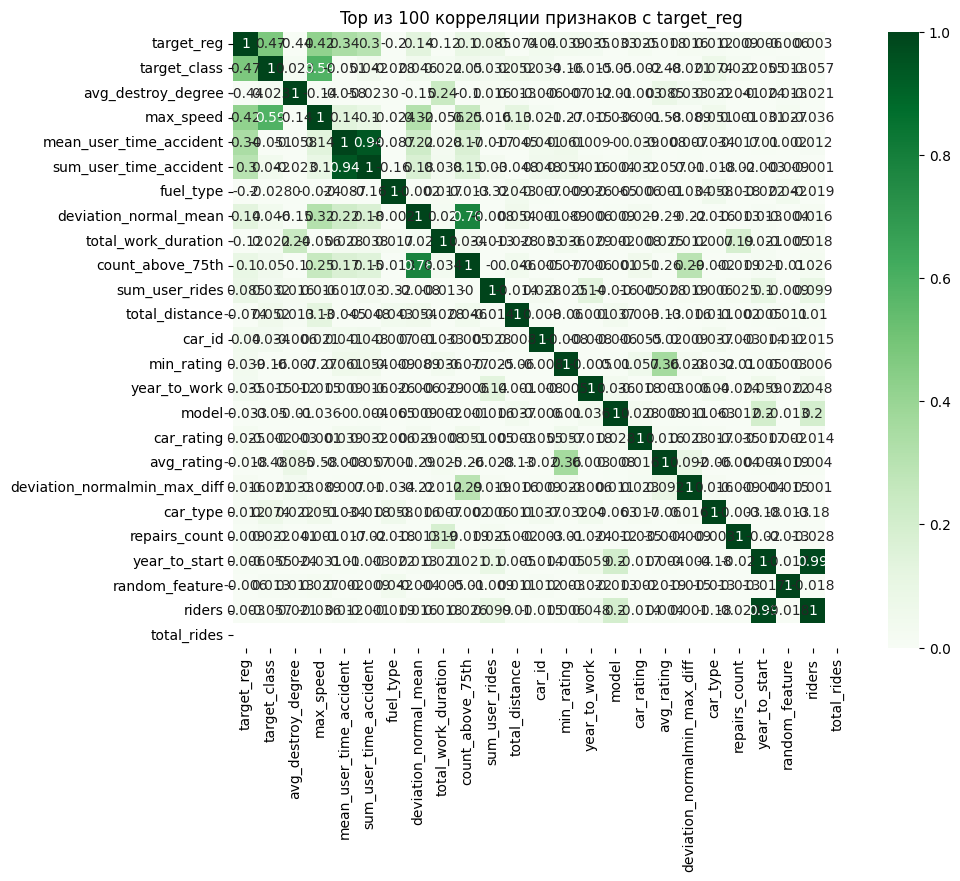

In [231]:
rarget_reg_pearson_corr_below_threshold = show_correlation_analysis(labeled_target_fitration_df, 'target_reg', 'random_feature', 100)

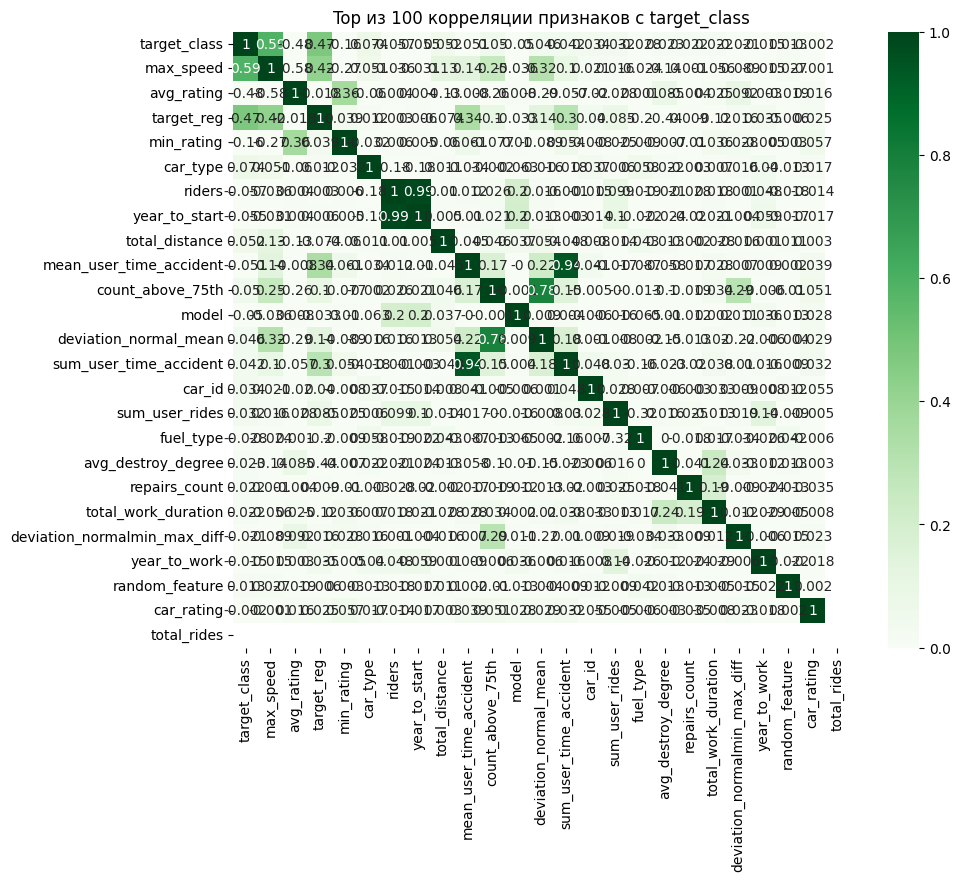

In [232]:
rarget_class_pearson_corr_below_threshold = show_correlation_analysis(labeled_target_fitration_df, 'target_class', 'random_feature', 100)

### Phik отбор

In [235]:
!pip install phik
import phik
from phik import report
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt

def show_correlation_by_phik_and_return_below_threshold(df, target_col_name, threshold_column, features_limit):
    phik_overview = df.phik_matrix().round(2)
    sorted_cols = phik_overview[target_col_name].abs().sort_values(ascending=False)
    top_features = sorted_cols.index[:features_limit + 1]
    filtered_phik_overview = phik_overview.loc[top_features, top_features]

    plot_correlation_matrix(filtered_phik_overview.values,
                            x_labels=filtered_phik_overview.columns,
                            y_labels=filtered_phik_overview.index,
                            vmin=0, vmax=1, color_map="Greens",
                            title="Phik Correlation",
                            fontsize_factor=1.2, figsize=(10, 7))
    plt.tight_layout()
    plt.show()

    threshold_index = sorted_cols.index.get_loc(threshold_column)
    features_below_threshold = sorted_cols.index[threshold_index:]
    correlations_below_threshold = sorted_cols.loc[features_below_threshold]
    return correlations_below_threshold.to_dict()

interval columns not set, guessing: ['car_id', 'model', 'car_type', 'fuel_type', 'car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'target_class', 'min_rating', 'avg_rating', 'total_distance', 'max_speed', 'total_rides', 'sum_user_rides', 'sum_user_time_accident', 'mean_user_time_accident', 'deviation_normal_mean', 'deviation_normalmin_max_diff', 'count_above_75th', 'repairs_count', 'avg_destroy_degree', 'total_work_duration', 'random_feature']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable total_rides for analysis 1. Dropping this column
  warnings.warn(


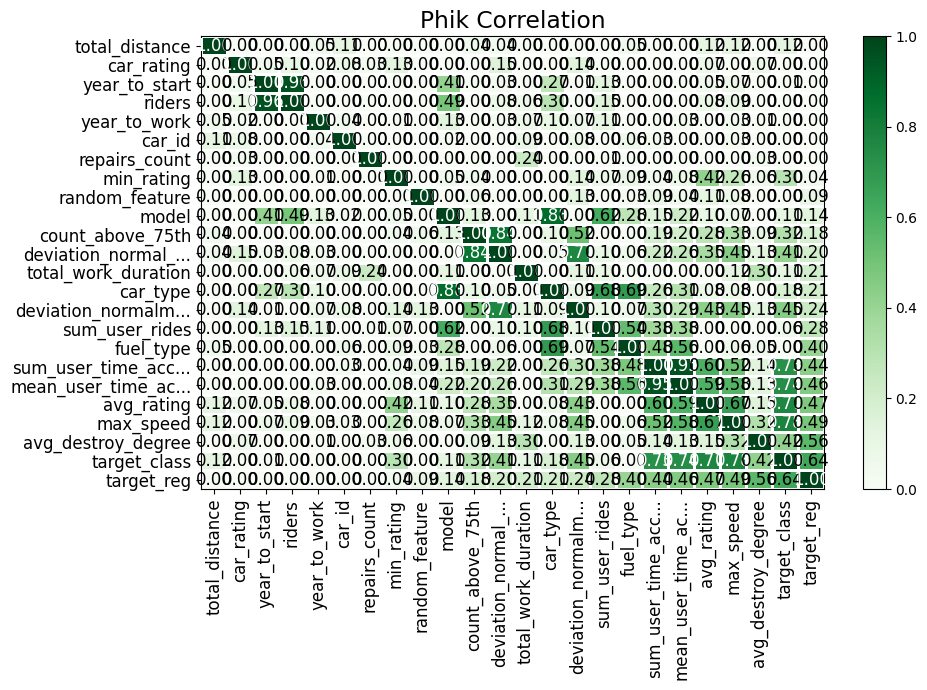

In [236]:
target_reg_phik_correlations_below_threshold = show_correlation_by_phik_and_return_below_threshold(labeled_target_fitration_df, 'target_reg', 'random_feature', 100)

In [237]:
target_reg_phik_correlations_below_threshold

{'random_feature': 0.09,
 'min_rating': 0.04,
 'repairs_count': 0.0,
 'car_id': 0.0,
 'year_to_work': 0.0,
 'riders': 0.0,
 'year_to_start': 0.0,
 'car_rating': 0.0,
 'total_distance': 0.0}

interval columns not set, guessing: ['car_id', 'model', 'car_type', 'fuel_type', 'car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'target_class', 'min_rating', 'avg_rating', 'total_distance', 'max_speed', 'total_rides', 'sum_user_rides', 'sum_user_time_accident', 'mean_user_time_accident', 'deviation_normal_mean', 'deviation_normalmin_max_diff', 'count_above_75th', 'repairs_count', 'avg_destroy_degree', 'total_work_duration', 'random_feature']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable total_rides for analysis 1. Dropping this column
  warnings.warn(


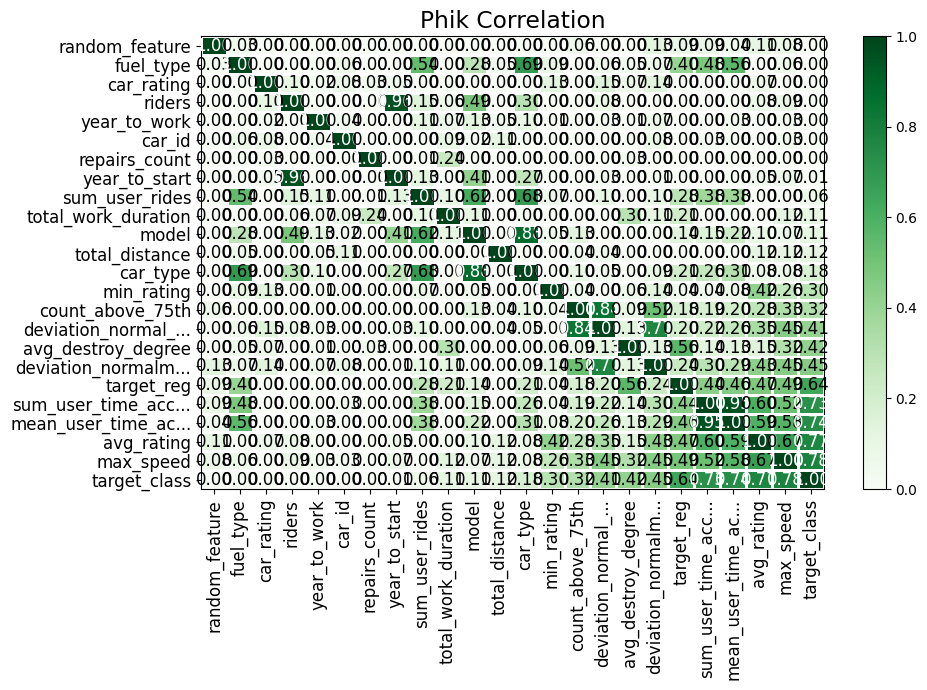

In [238]:
target_class_phik_correlations_below_threshold = show_correlation_by_phik_and_return_below_threshold(labeled_target_fitration_df, 'target_class', 'random_feature', 100)

In [239]:
target_class_phik_correlations_below_threshold

{'random_feature': 0.0}

### Shap отбор

In [270]:
# !pip install shap
# !pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap

from sklearn.preprocessing import LabelEncoder
import pandas as pd

def encode_categorical_features(df):
    encoders = {}
    df_encoded = df.copy()

    for column in df.columns:
        if df[column].dtype == 'object':
            le = LabelEncoder()
            df_encoded[column] = le.fit_transform(df[column])
            encoders[column] = le

    return df_encoded, encoders

def train_xgb_model(df, target_column, task_type='classification', model_params=None, test_size=0.2, random_state=42, n_estimators=100):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    if model_params is None:
        default_objective = 'multi:softprob' if task_type == 'classification' else 'reg:squarederror'
        default_eval_metric = 'mlogloss' if task_type == 'classification' else 'rmse'
        model_params = {
            'max_depth': 3, 'eta': 0.1,
            'objective': default_objective,
            'eval_metric': default_eval_metric
        }
        if task_type == 'classification':
            model_params['num_class'] = len(y.unique())
    bst = xgb.train(model_params, dtrain, n_estimators, evals=[(dtest, 'test')], early_stopping_rounds=10)
    return bst

def print_structure(obj, level=0):
    prefix = "  " * level  # Indentation for readability

    if isinstance(obj, list):
        print(f"{prefix}List of length {len(obj)}")
        if len(obj) > 0:
            print_structure(obj[0], level + 1)
    elif hasattr(obj, 'shape'):
        print(f"{prefix}Array with shape: {obj.shape}")
    else:
        print(f"{prefix}Type: {type(obj)}")

def generate_shap_summary_xgb(model, df, target_column, features_limit=100, task_type='classification'):
    X = df.drop(columns=[target_column])
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    if isinstance(shap_values, list):
        num_classes = len(shap_values)
    else:
        num_classes = shap_values.shape[-1]

    if task_type=='classification':
        for i in range(num_classes):
            class_shap_values = shap_values[i] if isinstance(shap_values, list) else shap_values[:, :, i]
            plt.figure()
            shap.summary_plot(class_shap_values, X, max_display=features_limit, show=False)
            plt.title(f"SHAP Summary график для класса {label_to_bug_dict[i]}")  # Adjust to use actual class names if you have them
            plt.show()
    else:
        shap.summary_plot(shap_values, X, max_display=features_limit)

    return shap_values

def get_shap_results(df_encoded, target_column, random_feature, task_type='classification', model_params=None, test_size=0.2, random_state=42, n_estimators=100, features_limit=25):
    bst_model = train_xgb_model(df_encoded, target_column, task_type, model_params, test_size, random_state, n_estimators)
    shap_values = generate_shap_summary_xgb(bst_model, df_encoded, target_column, features_limit, task_type)

    if task_type=='classification' and isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        # классификация
        mean_abs_shap_values = np.abs(shap_values).mean(axis=(0, 2))
    else:
        # регрессия
        mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

    mean_abs_shap_series = pd.Series(mean_abs_shap_values, index=df_encoded.drop(columns=[target_column]).columns)

    random_feature_value = mean_abs_shap_series[random_feature]

    filtered_shap_series = mean_abs_shap_series[mean_abs_shap_series <= random_feature_value].sort_values(ascending=False)

    return bst_model, filtered_shap_series

In [242]:
labeled_target_fitration_df, encoders = encode_categorical_features(labeled_target_fitration_df)

In [243]:
labeled_target_fitration_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   fuel_type                     2337 non-null   int64  
 4   car_rating                    2337 non-null   float64
 5   year_to_start                 2337 non-null   int64  
 6   riders                        2337 non-null   int64  
 7   year_to_work                  2337 non-null   int64  
 8   target_reg                    2337 non-null   float64
 9   target_class                  2337 non-null   int64  
 10  min_rating                    2337 non-null   float64
 11  avg_rating                    2337 non-null   float64
 12  total_distance                2337 non-null   float64
 13  max

[0]	test-mlogloss:1.84397
[1]	test-mlogloss:1.59478
[2]	test-mlogloss:1.41010
[3]	test-mlogloss:1.25901
[4]	test-mlogloss:1.13324
[5]	test-mlogloss:1.02673
[6]	test-mlogloss:0.93563
[7]	test-mlogloss:0.85506
[8]	test-mlogloss:0.78332
[9]	test-mlogloss:0.72269
[10]	test-mlogloss:0.66565
[11]	test-mlogloss:0.61440
[12]	test-mlogloss:0.57058
[13]	test-mlogloss:0.52880
[14]	test-mlogloss:0.49263
[15]	test-mlogloss:0.45822
[16]	test-mlogloss:0.42816
[17]	test-mlogloss:0.40024
[18]	test-mlogloss:0.37456
[19]	test-mlogloss:0.35054
[20]	test-mlogloss:0.32878
[21]	test-mlogloss:0.30923
[22]	test-mlogloss:0.29298
[23]	test-mlogloss:0.27590
[24]	test-mlogloss:0.26102
[25]	test-mlogloss:0.24679
[26]	test-mlogloss:0.23376
[27]	test-mlogloss:0.22147
[28]	test-mlogloss:0.21012
[29]	test-mlogloss:0.19962
[30]	test-mlogloss:0.18962
[31]	test-mlogloss:0.18151
[32]	test-mlogloss:0.17355
[33]	test-mlogloss:0.16618
[34]	test-mlogloss:0.15981
[35]	test-mlogloss:0.15415
[36]	test-mlogloss:0.14814
[37]	test-m

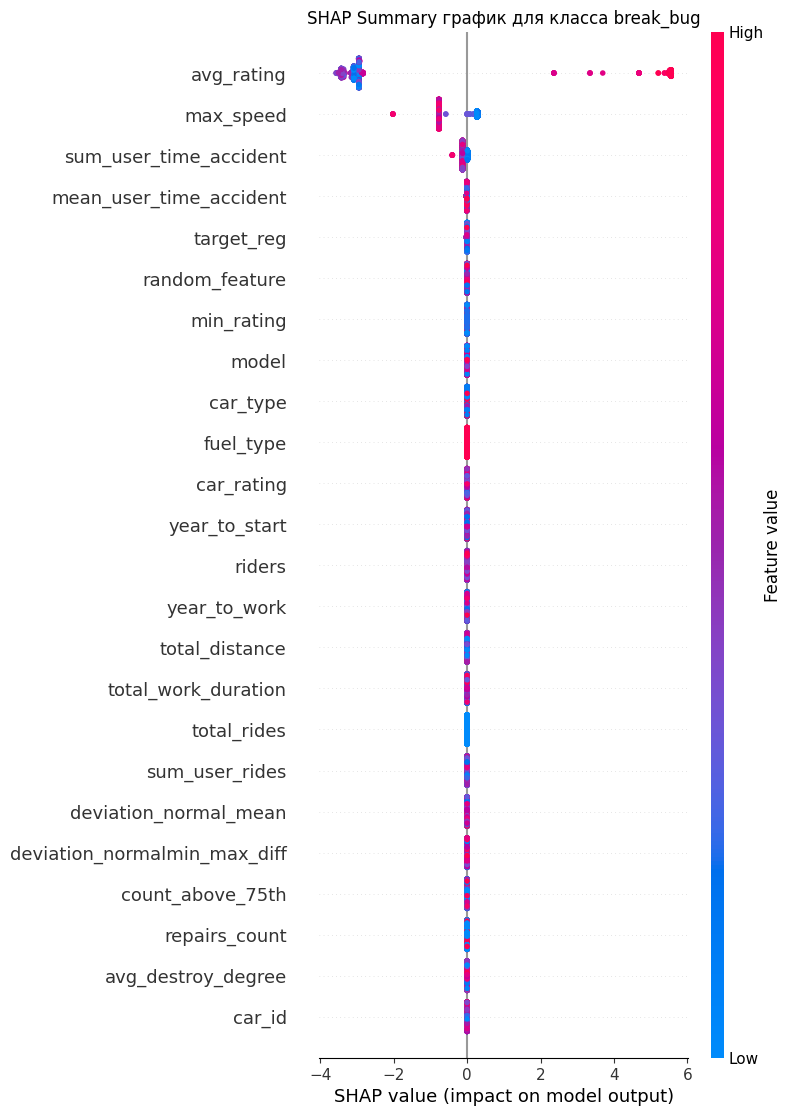

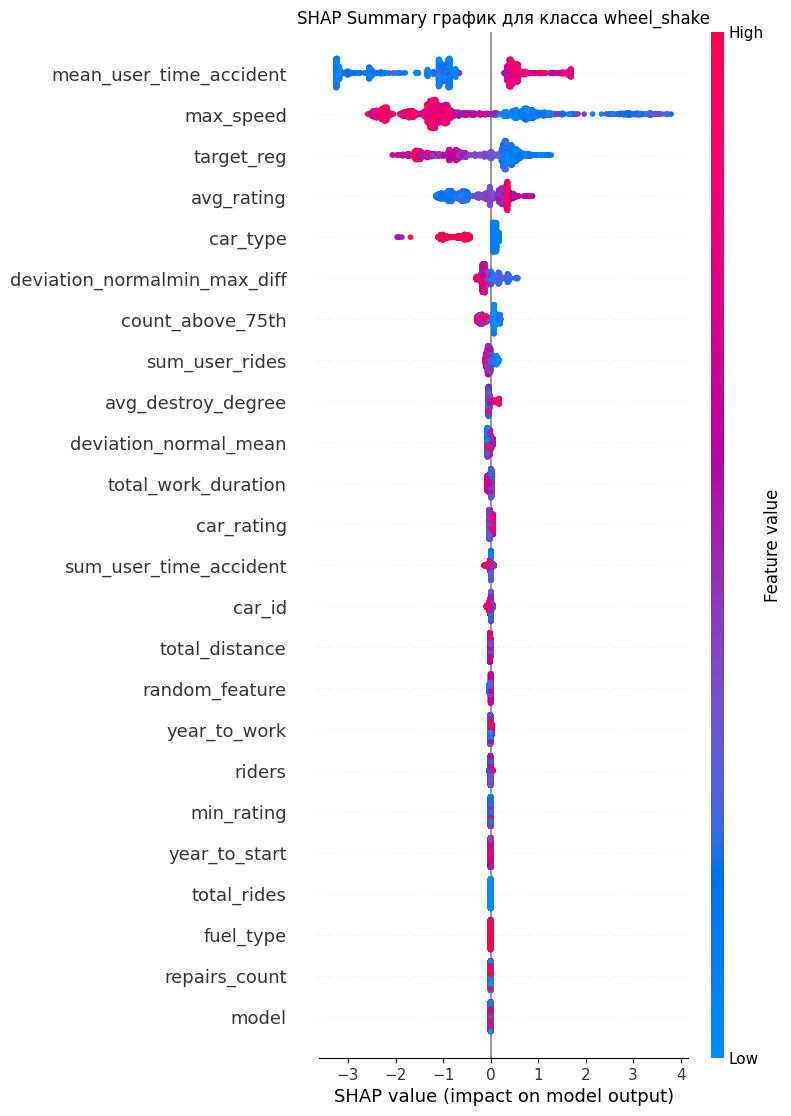

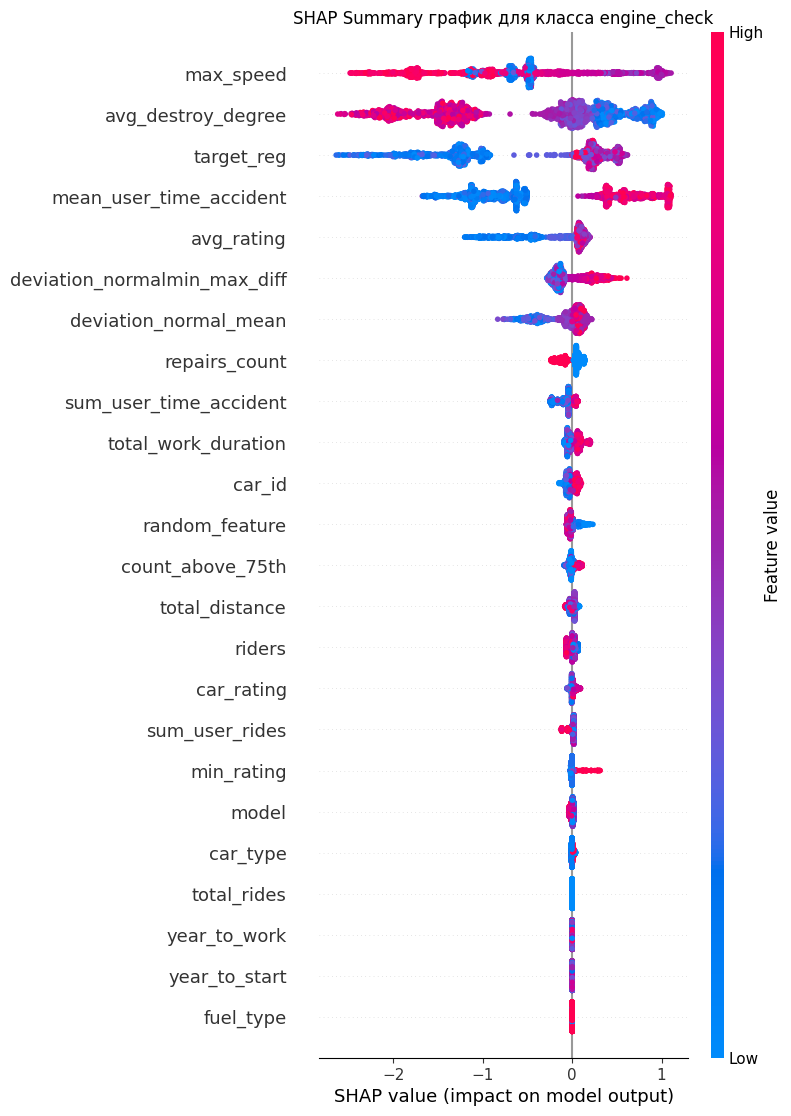

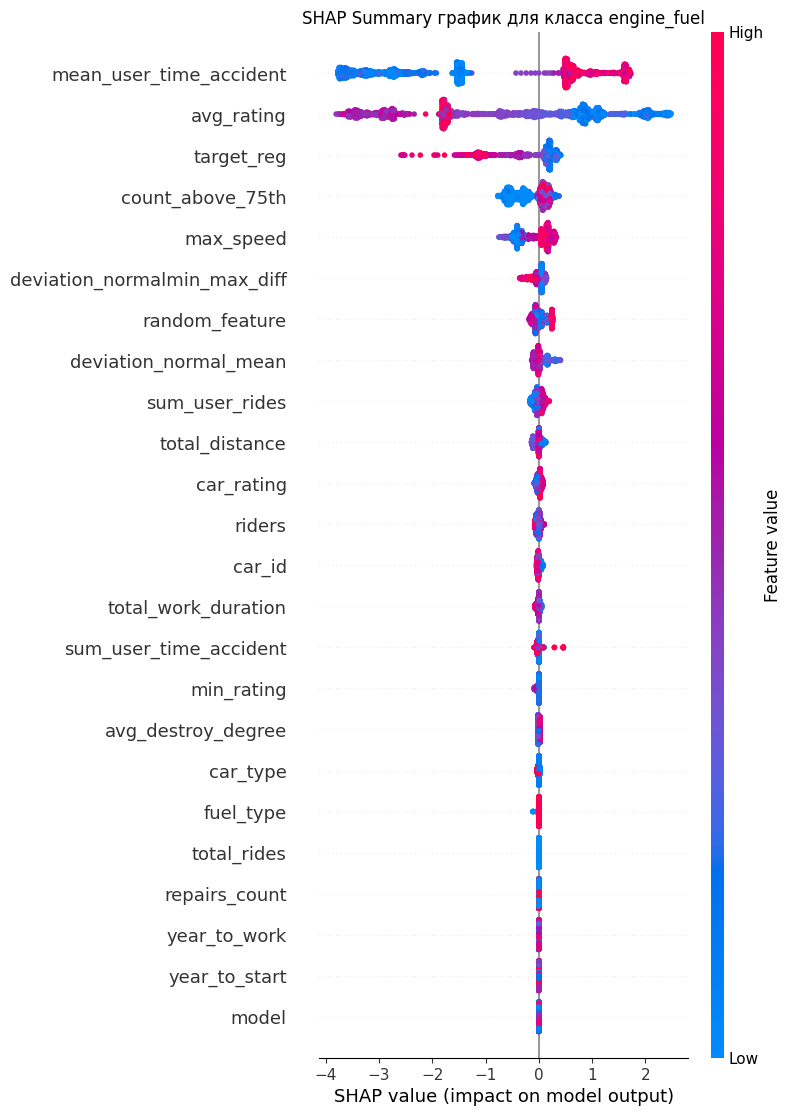

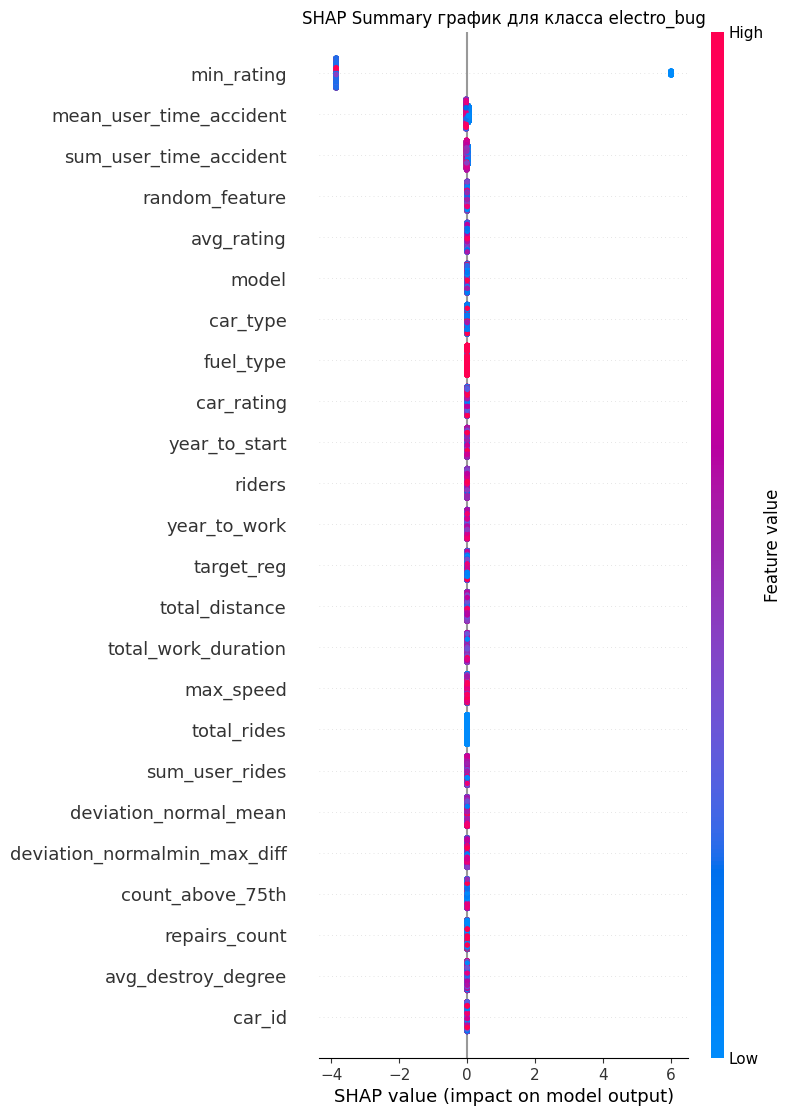

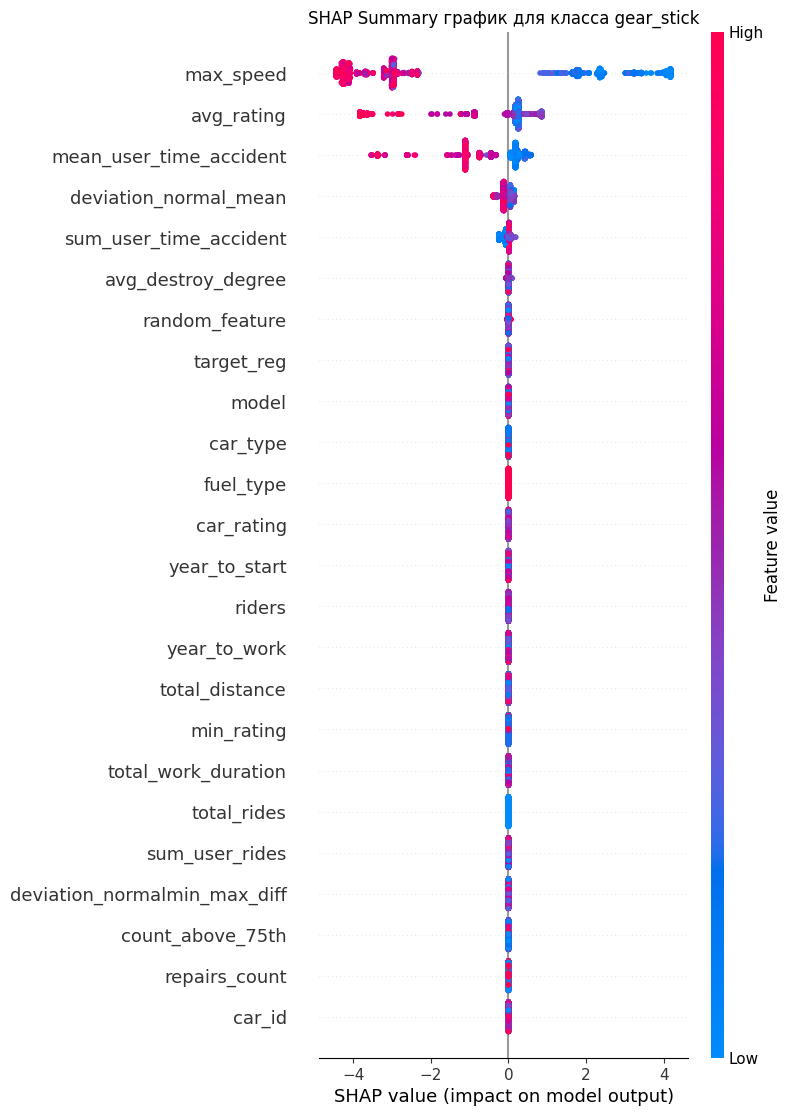

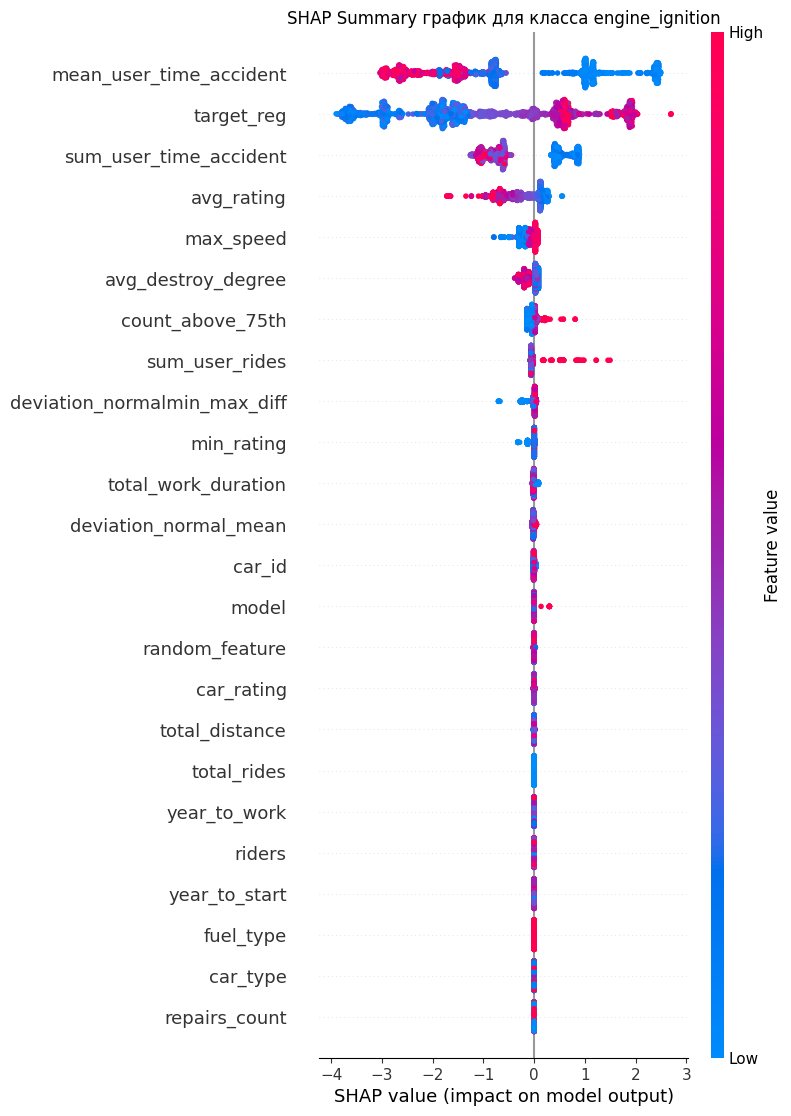

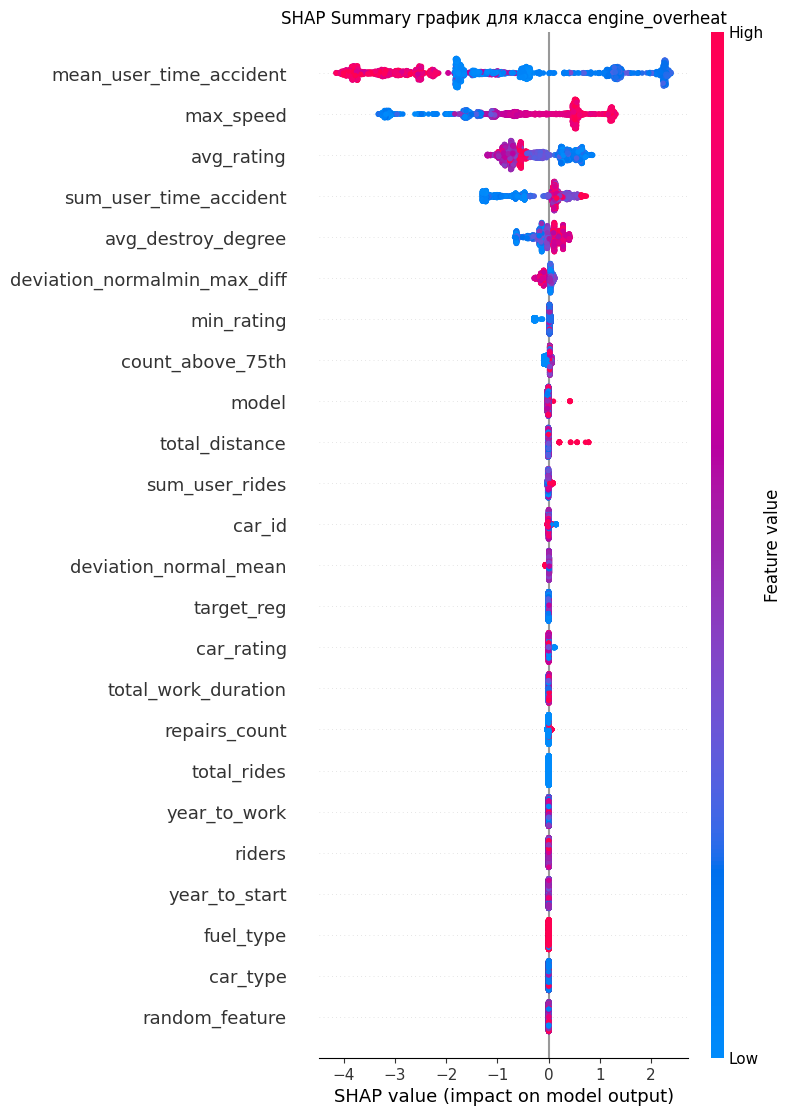

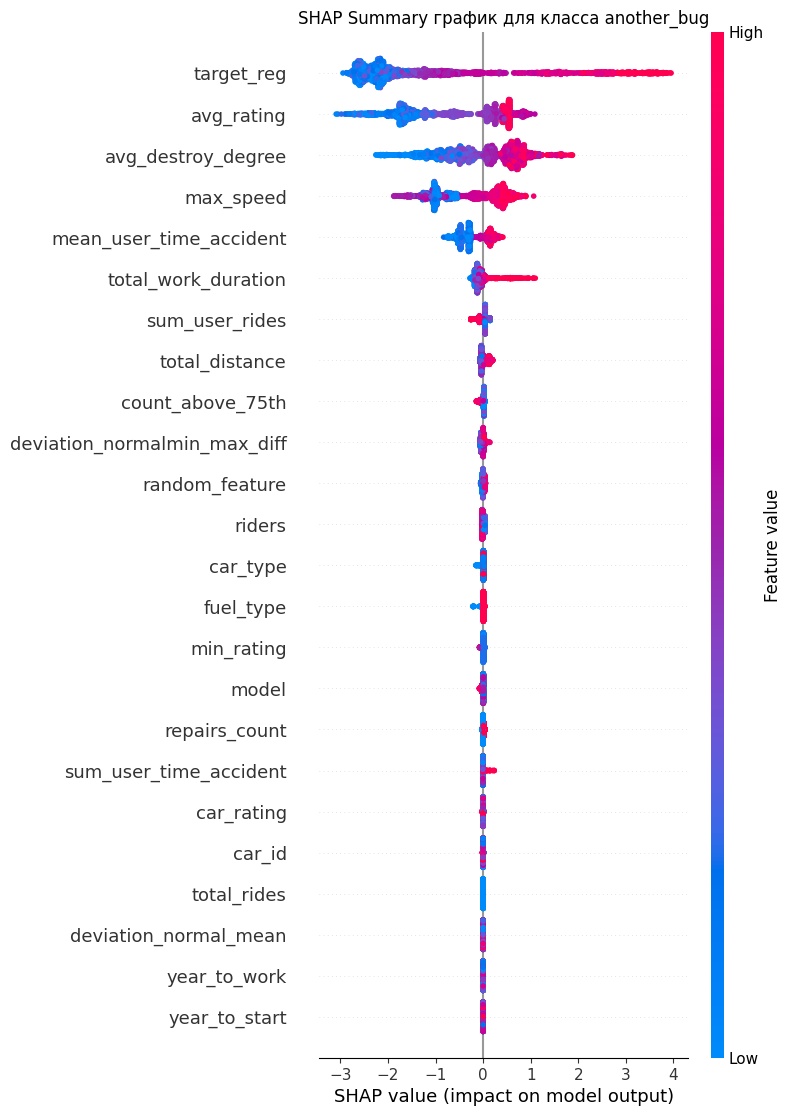

In [271]:
target_class_shap_results, target_class_mean_abs_shap_series = get_shap_results(labeled_target_fitration_df, 'target_class', 'random_feature')

In [272]:
target_class_mean_abs_shap_series

random_feature    0.016373
total_distance    0.014817
repairs_count     0.010349
car_id            0.010034
car_rating        0.008578
riders            0.007805
model             0.004050
fuel_type         0.001275
year_to_work      0.000667
year_to_start     0.000000
total_rides       0.000000
dtype: float32

[0]	test-rmse:17.06604
[1]	test-rmse:16.03083
[2]	test-rmse:15.15292
[3]	test-rmse:14.37245
[4]	test-rmse:13.67882
[5]	test-rmse:13.01981
[6]	test-rmse:12.48980
[7]	test-rmse:11.98736
[8]	test-rmse:11.47488
[9]	test-rmse:10.98870
[10]	test-rmse:10.59042
[11]	test-rmse:10.22713
[12]	test-rmse:9.97172
[13]	test-rmse:9.72151
[14]	test-rmse:9.49320
[15]	test-rmse:9.32512
[16]	test-rmse:9.15957
[17]	test-rmse:9.00029
[18]	test-rmse:8.84564
[19]	test-rmse:8.74015
[20]	test-rmse:8.65955
[21]	test-rmse:8.57671
[22]	test-rmse:8.45514
[23]	test-rmse:8.38008
[24]	test-rmse:8.27706
[25]	test-rmse:8.18328
[26]	test-rmse:8.12911
[27]	test-rmse:8.08223
[28]	test-rmse:8.04633
[29]	test-rmse:7.99839
[30]	test-rmse:7.95238
[31]	test-rmse:7.89026
[32]	test-rmse:7.85677
[33]	test-rmse:7.84791
[34]	test-rmse:7.80705
[35]	test-rmse:7.77358
[36]	test-rmse:7.74914
[37]	test-rmse:7.74984
[38]	test-rmse:7.72396
[39]	test-rmse:7.72041
[40]	test-rmse:7.68951
[41]	test-rmse:7.65162
[42]	test-rmse:7.64148
[43]	test

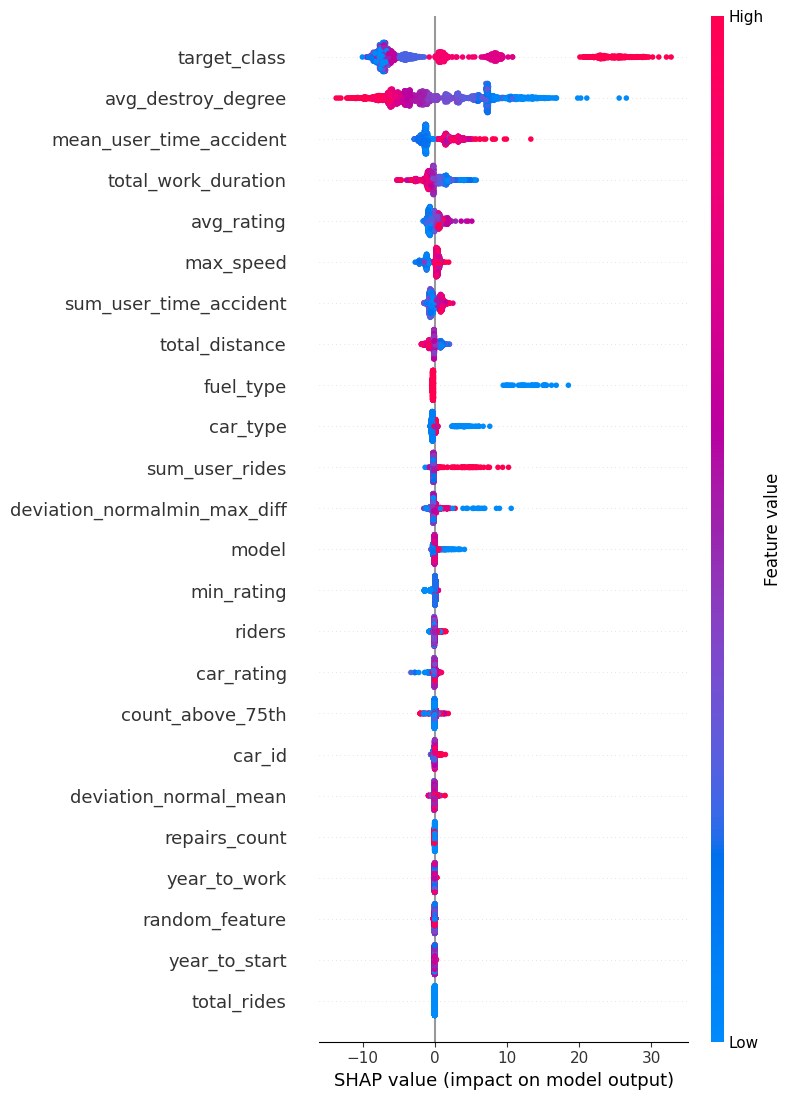

In [273]:
target_reg_shap_results, target_reg_mean_abs_shap_series = get_shap_results(labeled_target_fitration_df, 'target_reg', 'random_feature', 'regr')

In [275]:
target_class_mean_abs_shap_series

random_feature    0.016373
total_distance    0.014817
repairs_count     0.010349
car_id            0.010034
car_rating        0.008578
riders            0.007805
model             0.004050
fuel_type         0.001275
year_to_work      0.000667
year_to_start     0.000000
total_rides       0.000000
dtype: float32

### Отбор признаков, которые не попали хотя бы в одно из пересечений наборов для удаления на основе 2х методов

In [276]:
def intersection_of_dicts(pearson_corr_dict, phik_dict, shap_dict):
    print("Pearson корреляция словарь:", pearson_corr_dict)
    print("Phik словарь:", phik_dict)
    print("SHAP словарь:", shap_dict)

    all_three_intersection = set(pearson_corr_dict) & set(phik_dict) & set(shap_dict)
    print("Пересечения 3х:", all_three_intersection)

    pearson_phik_intersection = set(pearson_corr_dict) & set(phik_dict)
    print("Pearson и Phi_k пересечения:", pearson_phik_intersection)

    pearson_shap_intersection = set(pearson_corr_dict) & set(shap_dict)
    print("Pearson и SHAP пересечения:", pearson_shap_intersection)

    phik_shap_intersection = set(phik_dict) & set(shap_dict)
    print("Phi_k и SHAP пересечения:", phik_shap_intersection)

    return all_three_intersection, pearson_phik_intersection, pearson_shap_intersection, phik_shap_intersection

In [283]:
target_reg_all_three_intersection, target_reg_pearson_phik_intersection, target_reg_pearson_shap_intersection, target_reg_phik_shap_intersection = intersection_of_dicts(rarget_reg_pearson_corr_below_threshold, target_reg_phik_correlations_below_threshold, target_reg_mean_abs_shap_series.to_dict())

Pearson корреляция словарь: {'random_feature': 0.006, 'riders': 0.003, 'total_rides': nan}
Phik словарь: {'random_feature': 0.09, 'min_rating': 0.04, 'repairs_count': 0.0, 'car_id': 0.0, 'year_to_work': 0.0, 'riders': 0.0, 'year_to_start': 0.0, 'car_rating': 0.0, 'total_distance': 0.0}
SHAP словарь: {'random_feature': 0.006813542451709509, 'year_to_start': 0.001241384888999164, 'total_rides': 0.0}
Пересечения 3х: {'random_feature'}
Pearson и Phi_k пересечения: {'random_feature', 'riders'}
Pearson и SHAP пересечения: {'random_feature', 'total_rides'}
Phi_k и SHAP пересечения: {'year_to_start', 'random_feature'}


In [286]:
target_reg_intersections_union = target_reg_all_three_intersection | target_reg_pearson_phik_intersection | target_reg_pearson_shap_intersection | target_reg_phik_shap_intersection

In [295]:
target_class_all_three_intersection, target_class_pearson_phik_intersection, target_class_pearson_shap_intersection, target_class_phik_shap_intersection = intersection_of_dicts(rarget_class_pearson_corr_below_threshold, target_class_phik_correlations_below_threshold, target_class_mean_abs_shap_series.to_dict())

Pearson корреляция словарь: {'random_feature': 0.013, 'car_rating': 0.002, 'total_rides': nan}
Phik словарь: {'random_feature': 0.0}
SHAP словарь: {'random_feature': 0.01637345738708973, 'total_distance': 0.01481656078249216, 'repairs_count': 0.010349075309932232, 'car_id': 0.010033777914941311, 'car_rating': 0.008578191511332989, 'riders': 0.007805206812918186, 'model': 0.004050023853778839, 'fuel_type': 0.0012748932931572199, 'year_to_work': 0.0006668648566119373, 'year_to_start': 0.0, 'total_rides': 0.0}
Пересечения 3х: {'random_feature'}
Pearson и Phi_k пересечения: {'random_feature'}
Pearson и SHAP пересечения: {'car_rating', 'random_feature', 'total_rides'}
Phi_k и SHAP пересечения: {'random_feature'}


In [296]:
target_class_intersections_union = target_class_all_three_intersection | target_class_pearson_phik_intersection | target_class_pearson_shap_intersection | target_class_phik_shap_intersection

In [297]:
target_class_selected_features_df = labeled_target_fitration_df[[col for col in labeled_target_fitration_df.columns if col not in target_class_intersections_union]]

In [301]:
check_data_distribution(labeled_target_fitration_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   fuel_type                     2337 non-null   int64  
 4   car_rating                    2337 non-null   float64
 5   year_to_start                 2337 non-null   int64  
 6   riders                        2337 non-null   int64  
 7   year_to_work                  2337 non-null   int64  
 8   target_reg                    2337 non-null   float64
 9   target_class                  2337 non-null   int64  
 10  min_rating                    2337 non-null   float64
 11  avg_rating                    2337 non-null   float64
 12  total_distance                2337 non-null   float64
 13  max

In [298]:
check_data_distribution(target_class_selected_features_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   fuel_type                     2337 non-null   int64  
 4   year_to_start                 2337 non-null   int64  
 5   riders                        2337 non-null   int64  
 6   year_to_work                  2337 non-null   int64  
 7   target_reg                    2337 non-null   float64
 8   target_class                  2337 non-null   int64  
 9   min_rating                    2337 non-null   float64
 10  avg_rating                    2337 non-null   float64
 11  total_distance                2337 non-null   float64
 12  max_speed                     2337 non-null   float64
 13  sum

In [299]:
target_reg_selected_features_df = labeled_target_fitration_df[[col for col in labeled_target_fitration_df.columns if col not in target_reg_intersections_union]]

In [300]:
check_data_distribution(target_reg_selected_features_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   car_id                        2337 non-null   int64  
 1   model                         2337 non-null   int64  
 2   car_type                      2337 non-null   int64  
 3   fuel_type                     2337 non-null   int64  
 4   car_rating                    2337 non-null   float64
 5   year_to_work                  2337 non-null   int64  
 6   target_reg                    2337 non-null   float64
 7   target_class                  2337 non-null   int64  
 8   min_rating                    2337 non-null   float64
 9   avg_rating                    2337 non-null   float64
 10  total_distance                2337 non-null   float64
 11  max_speed                     2337 non-null   float64
 12  sum_user_rides                2337 non-null   int64  
 13  sum

In [302]:
train_xgb_model(target_class_selected_features_df, 'target_class', task_type='classification')

[0]	test-mlogloss:1.84399
[1]	test-mlogloss:1.59480
[2]	test-mlogloss:1.41009
[3]	test-mlogloss:1.25900
[4]	test-mlogloss:1.13325
[5]	test-mlogloss:1.02653
[6]	test-mlogloss:0.93564
[7]	test-mlogloss:0.85487
[8]	test-mlogloss:0.78294
[9]	test-mlogloss:0.72252
[10]	test-mlogloss:0.66548
[11]	test-mlogloss:0.61424
[12]	test-mlogloss:0.57042
[13]	test-mlogloss:0.52864
[14]	test-mlogloss:0.49248
[15]	test-mlogloss:0.45807
[16]	test-mlogloss:0.42801
[17]	test-mlogloss:0.40010
[18]	test-mlogloss:0.37442
[19]	test-mlogloss:0.35041
[20]	test-mlogloss:0.32871
[21]	test-mlogloss:0.30898
[22]	test-mlogloss:0.29252
[23]	test-mlogloss:0.27559
[24]	test-mlogloss:0.26068
[25]	test-mlogloss:0.24709
[26]	test-mlogloss:0.23390
[27]	test-mlogloss:0.22154
[28]	test-mlogloss:0.21068
[29]	test-mlogloss:0.19954
[30]	test-mlogloss:0.18971
[31]	test-mlogloss:0.18134
[32]	test-mlogloss:0.17319
[33]	test-mlogloss:0.16639
[34]	test-mlogloss:0.15994
[35]	test-mlogloss:0.15426
[36]	test-mlogloss:0.14830
[37]	test-m

In [303]:
train_xgb_model(target_reg_selected_features_df, 'target_reg', task_type='reg')

[0]	test-rmse:17.06604
[1]	test-rmse:16.03083
[2]	test-rmse:15.15292
[3]	test-rmse:14.37245
[4]	test-rmse:13.67882
[5]	test-rmse:13.01981
[6]	test-rmse:12.48980
[7]	test-rmse:11.98736
[8]	test-rmse:11.47488
[9]	test-rmse:10.98870
[10]	test-rmse:10.59042
[11]	test-rmse:10.22713
[12]	test-rmse:9.97172
[13]	test-rmse:9.72151
[14]	test-rmse:9.49320
[15]	test-rmse:9.32512
[16]	test-rmse:9.15957
[17]	test-rmse:9.00029
[18]	test-rmse:8.84564
[19]	test-rmse:8.74015
[20]	test-rmse:8.65955
[21]	test-rmse:8.57671
[22]	test-rmse:8.45514
[23]	test-rmse:8.38008
[24]	test-rmse:8.27706
[25]	test-rmse:8.18328
[26]	test-rmse:8.12911
[27]	test-rmse:8.08223
[28]	test-rmse:8.04633
[29]	test-rmse:7.99839
[30]	test-rmse:7.95238
[31]	test-rmse:7.89026
[32]	test-rmse:7.85677
[33]	test-rmse:7.84791
[34]	test-rmse:7.80705
[35]	test-rmse:7.77358
[36]	test-rmse:7.74914
[37]	test-rmse:7.74984
[38]	test-rmse:7.72396
[39]	test-rmse:7.72041
[40]	test-rmse:7.68951
[41]	test-rmse:7.65162
[42]	test-rmse:7.64148
[43]	test

### Выводы  
Были созданы признаки, для группировки сначало были объединены данные пользователей и поездок, а затем результат объединялся с данными набора для тренировки, к которым позже были добавлены оставшиеся данные.
Данные очищены.
С помощью трех методов были отобраны лучшие признаки путем подмешивания случайного признака.
Далее были отобраны на удаление те признаки, которые одновременно были рекомендованы любыми двуми подходами, что несколько улучшило результат.
В дальнейшем можно упростить задачу и перебрать все подряд forward selection, ведь признаков мало, но это решение не расширяемо.

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
features2drop = [...] # то, что надо выбросить
targets = [...] # таргеты
cat_features = [...] # категориальные признаки

num_features = [...] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

In [ ]:
# YOUR CODE HERE

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [ ]:
# YOUR CODE HERE

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.